# Grid states under uncertainty

Analyzing a power system for uncertain grid parameters is a relevant field for grid operation and planning.

Probabilistic power flow simulations allow to efficiently analyze a grid including parameters with randomly distributed parameters. Multiple randomly distributed parameters can be convolved via Fourier transformation or FFT.

Less performant but easy and flexible to use, time series simulations can produce the same results.
This tutorial shows how random distributed parameters can be taken into account with time series simulations.

First we start with the necessary imports.

In [81]:
from typing import Any
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandapower as pp

np.random.seed(10)

We use the CIGRE MV grid as an example.
We assume that both the loads at buses 4 and 9 and the generation at bus 10 are randomly distributed.
We assume a triangular distribution for the loads and a beta distribution for the PV generation.

In [54]:
#  CIGRE grid
net = pp.networks.create_cigre_network_mv(with_der="pv_wind")

# grid elements with uncertainty
load_r4 = net.load.index[net.load.bus == 4][0]
load_ci9 = net.load.index[net.load.bus == 9][0]
sgen_pv10 = net.sgen.index[net.sgen.bus == 10][0]

# amount of random values
n_random_values = 1000

# random values as timeseries data
load_r4_distr = np.random.triangular(0, 0.6, 1, n_random_values)
load_ci9_distr = np.random.triangular(0.3, 0.7, 1.2, n_random_values)
sgen_pv10_distr = np.random.beta(2, 2, n_random_values)

The time series data just generated looks as follows:

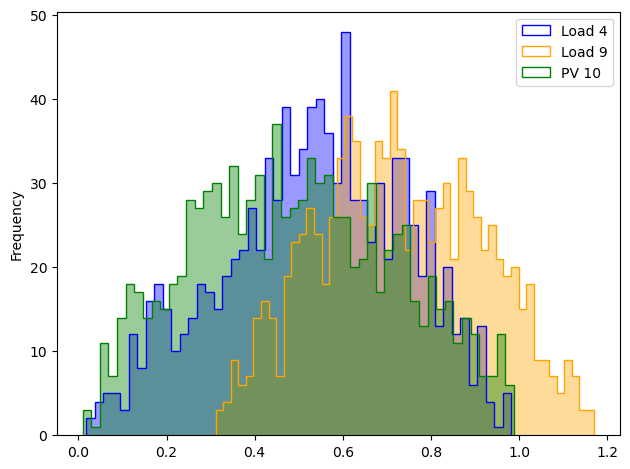

In [87]:
def hist_plot(
    bins: int,
    data: dict[str, Any],
) -> None:
    colors = [
        "blue",
        "orange",
        "green",
        "red",
        "purple",
        "brown",
        "pink",
        "gray",
        "olive",
        "cyan",
    ]
    if len(data.keys()) > len(colors):
        raise NotImplementedError(
            f"hist_plot() defines not enough colors internally. {len(colors)} colors are available "
            f"but the data requires {len(data.keys())}."
        )
    fig, ax = plt.subplots()
    for i, (key, values) in enumerate(data.items()):
        _ = ax.hist(values, bins=bins, edgecolor=colors[i], histtype="step", label=key)
        _ = ax.hist(values, bins=bins, color=colors[i], alpha=0.4)
    ax.set_ylabel("Frequency")
    plt.legend()
    plt.tight_layout()
    return fig, ax


fig, ax = hist_plot(
    50, {"Load 4": load_r4_distr, "Load 9": load_ci9_distr, "PV 10": sgen_pv10_distr}
)

Now we prepare the calculation of power flows with this randomly generated input data.

In [70]:
# construct time series DataFrame
power_df = pd.DataFrame(
    {
        "p_load_r4": net.load.at[load_r4, "p_mw"] * load_r4_distr,
        "q_load_r4": net.load.at[load_r4, "q_mvar"] * load_r4_distr,
        "p_load_ci9": net.load.at[load_ci9, "p_mw"] * load_ci9_distr,
        "q_load_ci9": net.load.at[load_ci9, "q_mvar"] * load_ci9_distr,
        "p_sgen_pv10": net.sgen.at[sgen_pv10, "p_mw"] * sgen_pv10_distr,
        "q_sgen_pv10": net.sgen.at[sgen_pv10, "q_mvar"] * sgen_pv10_distr,
    }
)
ts_data = pp.timeseries.DFData(power_df)

# create constant controllers for variable parameters
for et, var, eidx, pn in zip(
    ["load", "load", "sgen", "sgen"],
    ["p_mw", "q_mvar"] * 2,
    [[load_r4, load_ci9]] * 2 + [sgen_pv10] * 2,
    [
        ["p_load_r4", "p_load_ci9"],
        ["q_load_r4", "q_load_ci9"],
        "p_sgen_pv10",
        "q_sgen_pv10",
    ],
):
    _ = pp.control.ConstControl(
        net,
        element=et,
        variable=var,
        element_index=eidx,
        profile_name=pn,
        data_source=ts_data,
    )

# define output writer and desired variables to be saved
ow = pp.timeseries.OutputWriter(net)
ow.log_variable("res_bus", "vm_pu")
ow.log_variable("res_line", "loading_percent")
ow.log_variable("res_trafo", "loading_percent")

And finally perform the power flow calculations.

In [71]:
# run time series
pp.timeseries.run_timeseries(net, time_steps=range(n_random_values))
results_dict = ow.output

100%|██████████| 1000/1000 [00:20<00:00, 49.90it/s]


Die Netzzustände sind von den Eingangsdaten abhängig. Die resultierenden Verteilungen werden hier für die Spannungen, Transformatoren- und Leitungsauslastungen beispielhaft dargestellt:

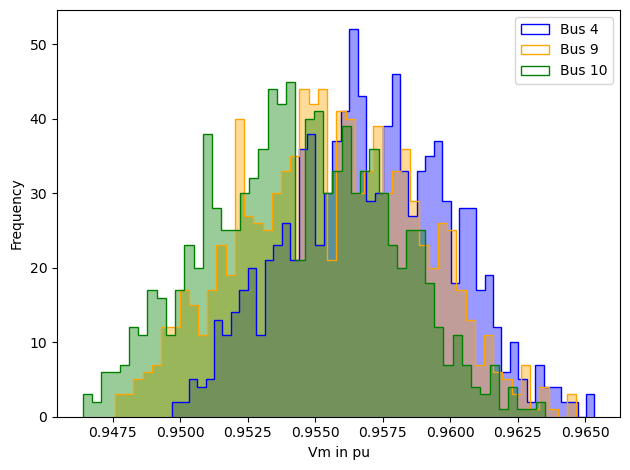

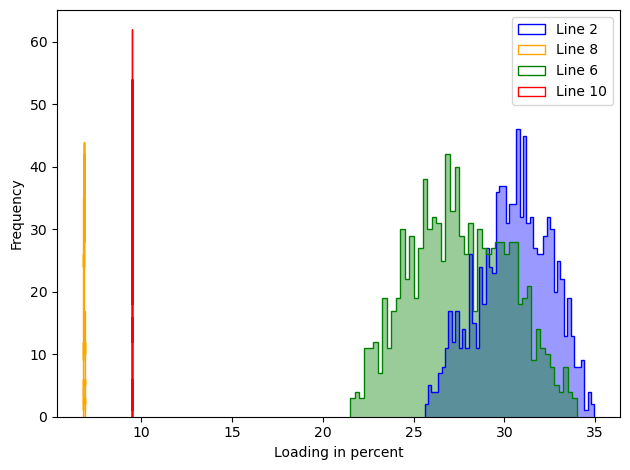

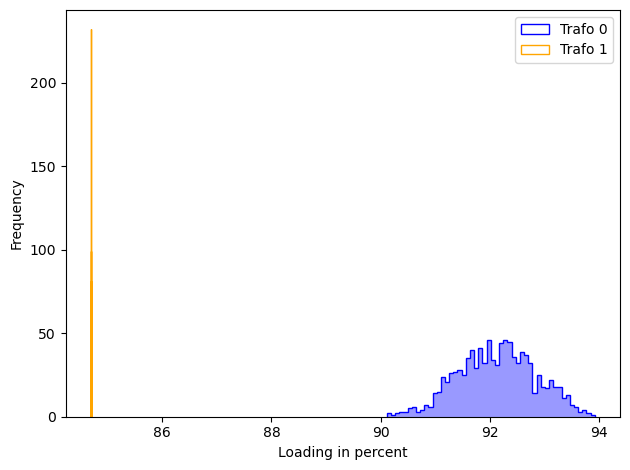

In [98]:
# voltages at buses 4, 7 and 9
fig, ax = hist_plot(
    50,
    {
        "Bus 4": results_dict["res_bus.vm_pu"][4],
        "Bus 9": results_dict["res_bus.vm_pu"][9],
        "Bus 10": results_dict["res_bus.vm_pu"][10],
    },
)
ax.set_xlabel("Vm in pu")
plt.tight_layout()

# loadings of lines 2, 8, 6 and 10
fig, ax = hist_plot(
    50,
    {
        "Line 2": results_dict["res_line.loading_percent"][2],
        "Line 8": results_dict["res_line.loading_percent"][8],
        "Line 6": results_dict["res_line.loading_percent"][6],
        "Line 10": results_dict["res_line.loading_percent"][10],
    },
)
ax.set_xlabel("Loading in percent")
plt.tight_layout()

# loadings of both transformers
fig, ax = hist_plot(
    50,
    {
        "Trafo 0": results_dict["res_trafo.loading_percent"][0],
        "Trafo 1": results_dict["res_trafo.loading_percent"][1],
    },
)
ax.set_xlabel("Loading in percent")
plt.tight_layout()

As we can see, Line 10 and Trafo 1 have no distribution since they are not effected by randomly distributed parameters located in the other feeder of the grid. Line 8 has a very narrow distribution, which can be seen more clearly in the following box plot.

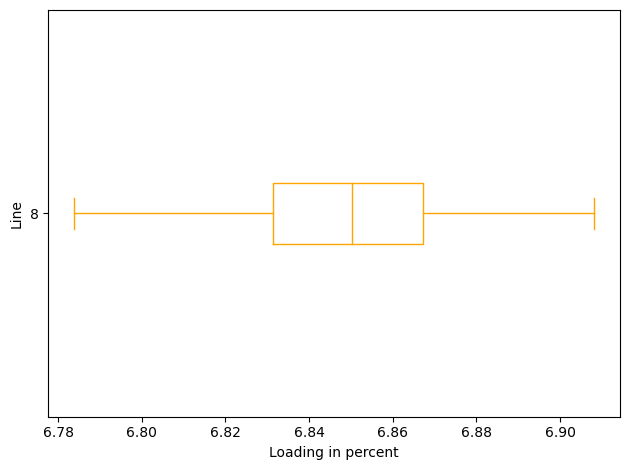

In [97]:
fig, ax = plt.subplots()
results_dict["res_line.loading_percent"][8].plot(
    kind="box", vert=False, color="orange", ax=ax
)
ax.set_ylabel("Line")
ax.set_xlabel("Loading in percent")
plt.tight_layout()